## 3.1 Scripting mit 3D Höhendaten

In diesem Notebook werden einige Möglichkeiten gezeigt, 
was wir nach dem Datendownload automatisiert machen können. 
Wir arbeiten zunächst mit einem kleinen Ausschnitt und dann auch in einem grösseren Bereich.

## swissalti3D von swisstopo


#### 3.1.1: Zunächst laden wir die Höhendaten herunter

Wir laden die Daten mit der Eiger Nordwand: <a href="https://map.geo.admin.ch/?lang=en&topic=ech&bgLayer=ch.swisstopo.swissimage&layers=ch.swisstopo.zeitreihen,ch.bfs.gebaeude_wohnungs_register,ch.bav.haltestellen-oev,ch.swisstopo.swisstlm3d-wanderwege,ch.astra.wanderland-sperrungen_umleitungen&layers_opacity=1,1,1,0.8,0.8&layers_visibility=false,false,false,false,false&layers_timestamp=18641231,,,,&E=2643240&N=1159850&zoom=5&crosshair=markere&layers_timestamp=18641231,,,,&E=2643220&N=1159610&zoom=5&crosshair=marker">map.geo.admin.ch</a>



In [1]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import shapely.wkt
import os
import geopandas_stac as stac
import geoutils

In [2]:
# Die Daten dieses Notebooks werden im Ordner daten/elv gespeichert
# Vorsicht bei Änderungen: basedir muss mit "/" enden!
basedir = "daten/elv/"

if not os.path.exists(basedir):
    os.mkdir(basedir)

In [3]:
# Eine Hilfsfunktion, welche zu einem PUNKT das entsprechende Rasterbild zurückgibt.
# Format: TIFF, GSD 0.5m
# Das Resultat ist eine Liste mit 0 oder 1 URL-Zeichenetten.

def getSwissalti3d_50cm_pt(lng, lat):
    df = stac.getAssets("ch.swisstopo.swissalti3d")

    df_geotiff = df.query('type == "image/tiff; application=geotiff; profile=cloud-optimized"')
    df_geotiff = df_geotiff.query("gsd == 0.5")

    point = shapely.geometry.Point(lng, lat)
    dfpoint = gpd.GeoDataFrame(geometry=gpd.GeoSeries(point, crs="epsg:4326"))

    df_result = gpd.sjoin(df_geotiff, dfpoint, op='contains')

    return stac.getUrlList(df_result)

In [4]:
# Eine Hilfsfunktion, welche zu einem POLYGON die entsprechenden Rasterbilder zurückgibt.
# Format: TIFF, GSD 0.5m
# Das Resultat ist eine Liste mit 0 oder n URL-Zeichenetten.

def getSwissalti3d_50cm_poly(wkt):
    df = stac.getAssets("ch.swisstopo.swissalti3d")

    df_geotiff = df.query('type == "image/tiff; application=geotiff; profile=cloud-optimized"')
    df_geotiff = df_geotiff.query("gsd == 0.5")

    polygon = shapely.wkt.loads(wkt)
    dfpoly = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygon, crs="epsg:4326"))
    df_result = gpd.sjoin(df_geotiff, dfpoly, op='intersects')
    
    return stac.getUrlList(df_result)

In [5]:
# Eiger Nordwand:
url = getSwissalti3d_50cm_pt(8.00283, 46.58162)

In [6]:
if len(url) == 0:
    print("**FEHLER** Kein Datensatz gefunden")
else:
    print(f"url: {url[0]}")

url: https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2643-1159/swissalti3d_2019_2643-1159_0.5_2056_5728.tif


In [7]:
filename = basedir + os.path.basename(url[0])
geoutils.download(url[0], filename, False)

100% done 	[****************************************************************************************************]


#### 3.1.2: Informationen über das File ansehen

Das gdal Tool "gdalinfo" kann dazu aufgerufen werden. https://gdal.org/programs/gdalinfo.html#gdalinfo

    gdalinfo [--help-general] [-json] [-mm] [-stats | -approx_stats] [-hist] [-nogcp] [-nomd]
         [-norat] [-noct] [-nofl] [-checksum] [-proj4]
         [-listmdd] [-mdd domain|`all`]* [-wkt_format WKT1|WKT2|...]
         [-sd subdataset] [-oo NAME=VALUE]* [-if format]* datasetname


Bei Shell-Kommandos können Python Variablennamen verwendet werden. Diese starten mit $

In [8]:
!gdalinfo $filename

Driver: GTiff/GeoTIFF
Files: daten/elv/swissalti3d_2019_2643-1159_0.5_2056_5728.tif
Size is 2000, 2000
Coordinate System is:
PROJCS["CH1903+ / LV95",
    GEOGCS["CH1903+",
        DATUM["CH1903+",
            SPHEROID["Bessel 1841",6377397.155,299.1528128,
                AUTHORITY["EPSG","7004"]],
            TOWGS84[674.374,15.056,405.346,0,0,0,0],
            AUTHORITY["EPSG","6150"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4150"]],
    PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
    PARAMETER["latitude_of_center",46.95240555555556],
    PARAMETER["longitude_of_center",7.439583333333333],
    PARAMETER["azimuth",90],
    PARAMETER["rectified_grid_angle",90],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",2600000],
    PARAMETER["false_northing",1200000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["East

Kompression LZW problematisch bei Höhenwerten, weil alles entpackt werden muss (zählt Anzahl gleicher Pixel und zählt sie zusammen)

Overviews: = Pyramidendaten ==> heikel und mögliche Fehlerquelle, man muss die Höhendaten von der richtigen Ebene nehmen

#### 3.1.3: Laden, Maximalhöhe bestimmen und plotten

In [45]:
dataset = rasterio.open(filename)

In [46]:
dataset.dtypes

('float32',)

In [11]:
dataset.count

1

In [12]:
data = dataset.read(1)

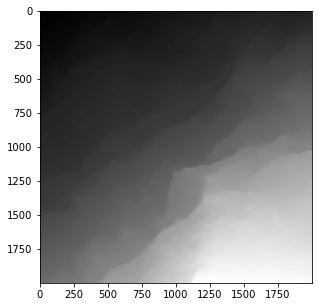

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(data, cmap='gray', interpolation='bilinear');

In [14]:
# Maximaler Höhenwert
np.max(data)

3635.1514

In [15]:
# Index, wo der Maximalwert ist:
indices = np.where(data == data.max())

In [16]:
print(indices)

(array([1999]), array([1224]))


In [17]:
jmax = indices[0][0]
imax = indices[1][0]

print(imax,jmax)

1224 1999


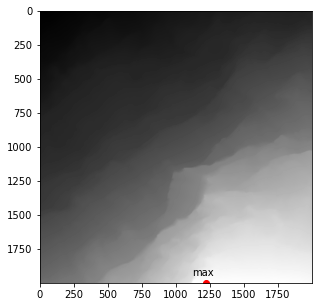

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(data, cmap='gray', interpolation='bilinear')
ax.plot(imax,jmax, 'ro')
ax.text(imax-100, jmax-50, "max");

Welche Koordinate (LV95) hat das Maximum ?

In [19]:
dataset.transform * (imax, jmax)

(2643612.0, 1159000.5)

In [20]:
dataset.close()

#### 3.1.4: Höhenlinien generieren

Mit dem Tool gdal_contour können Höhenlinien erstellt werden. Das Resultat wird als Vektor-Datensatz gespeichert.

https://gdal.org/programs/gdal_contour.html

In [21]:
!gdal_contour -a elev $filename daten/elv/contour.shp -i 150.0

0...10...20...30...40...50...60...70...80...90...100 - done.


In [22]:
contour = gpd.read_file("daten/elv/contour.shp")
len(contour)

13

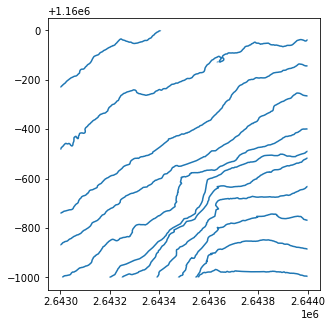

In [23]:
ax = contour.plot(figsize=(5,5));

##### Die Daten überlagern

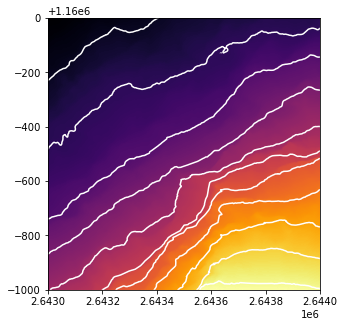

In [24]:
dataset = rasterio.open(filename)
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(dataset, cmap='inferno', ax=ax)
contour.plot(ax=ax, facecolor='none', edgecolor='white');
dataset.close()

#### 3.1.5 Geländeschummerung

mit gdaldem können verschiedene Visualisierungen wie Geländerschummerung, Farbrelief und mehr realisiert werden. Die Eigernordwand ist allerdings nicht wirklich das beste Beispiel dafür. 

https://gdal.org/programs/gdaldem.html

In [25]:
!gdaldem hillshade $filename daten/elv/hillshade.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


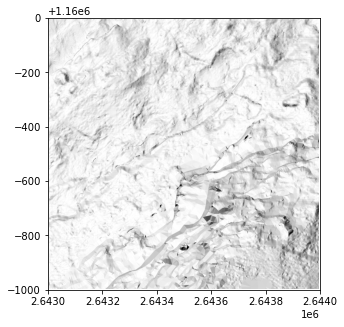

In [26]:
dataset = rasterio.open("daten/elv/hillshade.tif")
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(dataset, cmap='gray', ax=ax)
dataset.close()

#### 3.1.6 Skalieren

Mit dem Tool gdal_translate können raster daten konvertiert zwischen verschiedenen formaten konvertiert werden. Es kann auch ein resampling, oder reprojektion gemacht werden.

In diesem Beispiel skalieren wir das Bild.

https://gdal.org/programs/gdal_translate.html

In [27]:
!gdal_translate -of GTiff $filename daten/elv/skaliert.tif -outsize 500 0 -a_srs EPSG:2056

Input file size is 2000, 2000
0...10...20...30...40...50...60...70...80...90...100 - done.


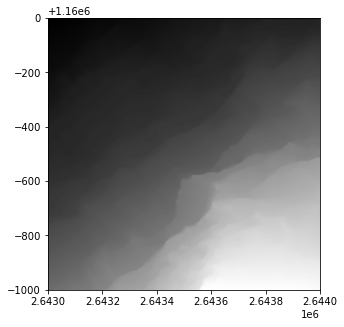

In [28]:
dataset = rasterio.open("daten/elv/skaliert.tif")
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(dataset, cmap='gray', ax=ax)
dataset.close()

In [29]:
!gdalinfo daten/elv/skaliert.tif

Driver: GTiff/GeoTIFF
Files: daten/elv/skaliert.tif
Size is 500, 500
Coordinate System is:
PROJCS["CH1903+ / LV95",
    GEOGCS["CH1903+",
        DATUM["CH1903+",
            SPHEROID["Bessel 1841",6377397.155,299.1528128,
                AUTHORITY["EPSG","7004"]],
            TOWGS84[674.374,15.056,405.346,0,0,0,0],
            AUTHORITY["EPSG","6150"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4150"]],
    PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],
    PARAMETER["latitude_of_center",46.95240555555556],
    PARAMETER["longitude_of_center",7.439583333333333],
    PARAMETER["azimuth",90],
    PARAMETER["rectified_grid_angle",90],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",2600000],
    PARAMETER["false_northing",1200000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NO

#### 3.1.7 Ein 3D Modell erstellen


Aus den Höhendaten kann relativ einfach ein 3D Objekt erstellt werden. Dazu müssen wir kurz das Wavefront OBJ Format ansehen. Das ist ein textbasiertes 3D Format, welches sehr einfach aufgebaut ist. Ein Würfel wird folgendermassen generiert:

```
v 1.0 -1.0 -1.0
v 1.0 -1.0 1.0
v -1.0 -1.0 1.0
v -1.0 -1.0 -1.0
v 1.0 1.0 -1.0
v 1.0 1.0 1.0
v -1.0 1.0 1.0
v -1.0 1.0 -1.0

f 2 3 4
f 8 7 6
f 5 6 2
f 6 7 3
f 3 7 8
f 1 4 8
f 1 2 4
f 5 8 6
f 1 5 2
f 2 6 3
f 4 3 8
f 5 1 8
```

Startet die Zeile mit `v`, so wird ein Vertex (Punkt) definiert.
Nach diesen definitionen kann mit `f` ein Face (Oberfläche, Polygon) generiert werden. Die Punkte werden als Index genommen, wobei der erste Vertex den Index 1 hat.

Das Format hat noch einige andere Attribute und möglichkeiten so können mit `vt` auch Texturkoordinaten und mit `vn` Normalen definiert werden. Bei den faces können dann auch normalen und texturkoodinaten angegeben werden (getrennt durch einen Slash).

Beispiele von .obj Files können hier gefunden werden: https://people.sc.fsu.edu/~jburkardt/data/obj/obj.html

OBJ lässt sich übrigens problemlos auch mit FME in andere Formate konvertieren.



In [30]:

# Wir nehmen das skalierte File, um es überschaubar zu machen, aber es ist natürlich
# kein Problem hier auch die Originalauflösung zu nehmen.
dataset = rasterio.open("daten/elv/skaliert.tif")

elv = dataset.read(1)

# Die Mitte in LV95. Wird als offset genommen, dann ist das Modell zentriert
center = dataset.transform * (dataset.width/2,dataset.height/2)


In [31]:
file = open("daten/elv/mesh.obj", "w")
file.write("# Terrain, created with Python\n#\n#\n")
file.write(f"# Offset: {center}\n\n")
 
## Vertices v ==> Höhenwerte, Position; x,y LV95 Koordinate, z Höhe
for y in range(dataset.height):
    for x in range(dataset.width):
        
        vx, vz = dataset.transform * (dataset.width-x,y)
        # offset, damit es nicht um den Nullpunkt rotiert
        vx -= center[0]
        vz -= center[1]
        vy = elv[y][x]
        
        file.write(f"v {vx} {vy} {vz}\n")

file.write("\n\n")
           
# indices    
for y in range(dataset.height-1):
    for x in range(dataset.width-1):
        q0 = y*dataset.width+x
        q1 = q0+1
        q2 = (y+1)*dataset.width+x
        q3 = q2+1
        
        file.write(f"f {q0+1}/{q0+1} {q2+1}/{q2+1} {q1+1}/{q1+1}\n") # first triangle
        file.write(f"f {q2+1}/{q2+1} {q3+1}/{q3+1} {q1+1}/{q1+1}\n") # second triangle
        
file.close()
           
           
elv = 0        
dataset.close()

Nun können wir das 3D Modell in einem beliebigen 3D Viewer ansehen, z.B. Meshlab:

https://www.meshlab.net/

#### 3.1.8 Grosser Ausschnitt

<a href="https://map.geo.admin.ch/?lang=en&topic=ech&bgLayer=ch.swisstopo.pixelkarte-farbe&layers=ch.swisstopo.zeitreihen,ch.bfs.gebaeude_wohnungs_register,ch.bav.haltestellen-oev,ch.swisstopo.swisstlm3d-wanderwege,ch.astra.wanderland-sperrungen_umleitungen,KML%7C%7Chttps:%2F%2Fpublic.geo.admin.ch%2Fp3Ih91bqTRuul4XjC0PIcg&layers_opacity=1,1,1,0.8,0.8,1&layers_visibility=false,false,false,false,false,true&layers_timestamp=18641231,,,,,&E=2678450&N=1209850&zoom=4&crosshair=marker">map.geo.admin.ch: Ausschnitt Rigi</a>


'POLYGON ((8.37645402594779 47.09477897404989, 8.543027723323302 47.09194937593571, 8.539901799919873 46.97188385130637, 8.371713837783513 46.97382585920817, 8.37645402594779 47.09477897404989))'

In [32]:
s = 'POLYGON ((8.37645402594779 47.09477897404989, 8.543027723323302 47.09194937593571, 8.539901799919873 46.97188385130637, 8.371713837783513 46.97382585920817, 8.37645402594779 47.09477897404989))'
urls = getSwissalti3d_50cm_poly(s)

In [33]:
len(urls)

195

In [34]:
# **WARNUNG**: Falls dieses Notebook lokal ausgeführt, wird, muss dieser Pfad angepasst werden

basedir2 = "/data/geo/opengeodata/elv/rigi/"
#basedir2 = "daten/elv/rigi/"   # nur bei lokaler Ausführung

if not os.path.exists(basedir2):
    os.makedirs(basedir2)

In [35]:
for url in urls:
    filename = basedir2 + os.path.basename(url)
    geoutils.download(url, filename, False)  # mit dem False wird verhindert, dass neu heruntergeladen wird

File https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2020_2683-1215/swissalti3d_2020_2683-1215_0.5_2056_5728.tif already exists, not overwriting.          

In [36]:
# **FIX**
# Overviews / Pyramiden entfernen:

for url in urls:
    filename = basedir2 + os.path.basename(url)
    !gdaladdo -clean $filename

In [37]:
vrt = basedir2 + "rigi.vrt"
tifs = basedir2 + "*.tif"

In [38]:
# VRT virtueller Datensatz erstellen
# nur wenn Notebook lokal, dann muss das ausgeführt werden, ansonsten ist das bereits auf dem Server

#!gdalbuildvrt $vrt $tifs

In [39]:
# Bildpyramiden/Overviews über den zusammengesetzen Datensatz rechnen
# nur wenn Notebook lokal, dann muss das ausgeführt werden, ansonsten ist das bereits auf dem Server

#!gdaladdo -r average $vrt 2 4 8 16 32

In [40]:
!gdalinfo $vrt

Driver: VRT/Virtual Raster
Files: /data/geo/opengeodata/elv/rigi/rigi.vrt
       /data/geo/opengeodata/elv/rigi/rigi.vrt.ovr
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1202_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1203_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1204_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1205_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1207_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1208_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1209_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1212_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1213_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissalti3d_2019_2671-1214_0.5_2056_5728.tif
       /data/geo/opengeodata/elv/rigi/swissal

**skalieren**

Ein skaliertes 1000x1000 Raster im lokalen Ordner erstellen

In [41]:
!gdal_translate -of GTiff $vrt daten/elv/rigi.tif -outsize 1000 0 -a_srs EPSG:2056

Input file size is 26000, 30000
0...10...20...30...40...50...60...70...80...90...100 - done.


**hillshade**

Ein Hillshade vom skalierten Bild erstellen und darstellen

In [42]:
!gdaldem hillshade daten/elv/rigi.tif daten/elv/hillshade2.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


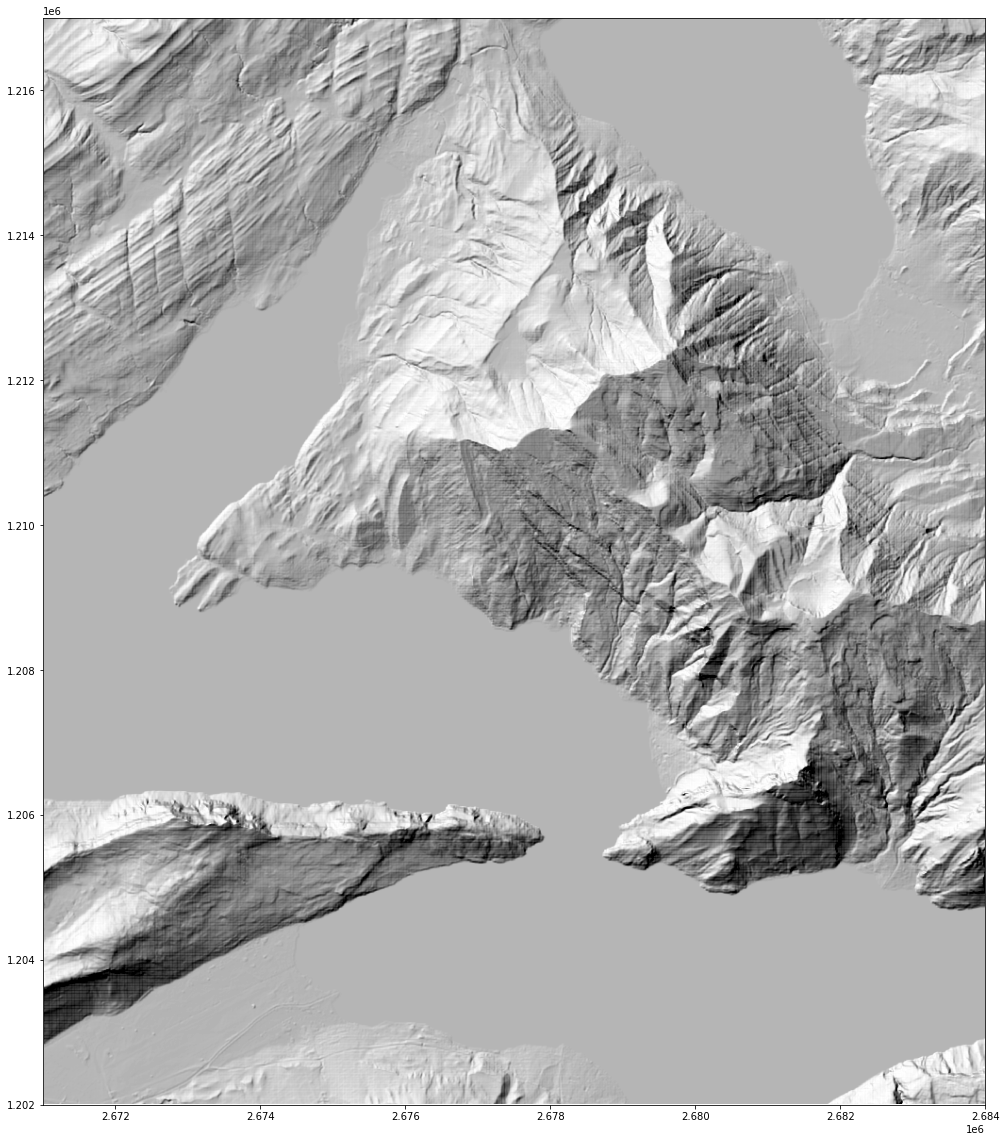

In [43]:
dataset = rasterio.open("daten/elv/hillshade2.tif")
fig, ax = plt.subplots(figsize=(20, 20))
rasterio.plot.show(dataset, cmap='gray', ax=ax)
dataset.close()

**3D Modell**

Ein Wavefront OBJ vom skalierten Bild erstellen. Der Code von oben wird einfach kopiert und der Pfad angepasst...

In [44]:
# Wir nehmen das skalierte File, um es überschaubar zu machen, aber es ist natürlich
# kein Problem hier auch die Originalauflösung zu nehmen.
dataset = rasterio.open("daten/elv/rigi.tif")

elv = dataset.read(1)

# Die Mitte in LV95. Wird als offset genommen, dann ist das Modell zentriert
center = dataset.transform * (dataset.width/2,dataset.height/2)

file = open("daten/elv/rigi.obj", "w")
file.write("# Terrain, created with Python\n#\n#\n")
file.write(f"# Offset: {center}\n\n")
 
## Vertices v
for y in range(dataset.height):
    for x in range(dataset.width):
        
        vx, vz = dataset.transform * (dataset.width-x,y)
        vx -= center[0]
        vz -= center[1]
        vy = elv[y][x]
        
        file.write(f"v {vx} {vy} {vz}\n")

file.write("\n\n")
           
# indices    
for y in range(dataset.height-1):
    for x in range(dataset.width-1):
        q0 = y*dataset.width+x
        q1 = q0+1
        q2 = (y+1)*dataset.width+x
        q3 = q2+1
        
        file.write(f"f {q0+1}/{q0+1} {q2+1}/{q2+1} {q1+1}/{q1+1}\n") # first triangle
        file.write(f"f {q2+1}/{q2+1} {q3+1}/{q3+1} {q1+1}/{q1+1}\n") # second triangle

        
file.close()
           
           
elv = 0        
dataset.close()